# Annex 2: Three-Way Algorithm Comparison

---

## 1. Introduction

---

This annex compares the final policy quality of three different optimization approaches applied to the LunarLander-v3 environment: DQN (Deep Q-Network), PPO (Proximal Policy Optimization), and a genetic algorithm (GA). DQN and PPO are gradient-based deep reinforcement learning methods covered in the main report. The GA is a gradient-free evolutionary method included as an additional reference point.

All three methods were trained on the same environment with the same set of random seeds [42, 123, 3407]. However, their training methodologies differ substantially:

| Aspect | DQN / PPO | GA |
|--------|-----------|----|
| Optimization | Gradient descent (backpropagation) | Evolutionary (selection, crossover, mutation) |
| Network size | 8-256-256-4 (~70k parameters) | 8-10-10-4 (244 parameters) |
| Training budget | 1.5M environment steps | ~225M environment steps |
| Gradient required | Yes | No |
| Temporal credit assignment | Yes (TD learning / advantages) | No (scalar fitness only) |

The training budgets are not directly comparable. DQN and PPO each used 1.5M environment steps with gradient-based optimization, while the GA required approximately 225M environment interactions (150x more) without any gradient computation. This difference is inherent to the respective algorithms: evolutionary methods require significantly more samples because they receive no directional feedback per weight, only a scalar fitness signal per genome.

The comparison focuses on **final policy quality** rather than sample efficiency, addressing the question: given sufficient training, how do the resulting policies compare in terms of landing performance?

In [1]:
import os, sys, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

import imageio
from IPython.display import Image, display

# GA inference
from genetic.evolution.neural_network import NeuralNetwork

In [2]:
# Configuration

SEED_LIST = [42, 123, 3407]

ALGORITHM_MAP = {
    "dqn": DQN,
    "ppo": PPO,
}

NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
GYMNASIUM_MODEL = "LunarLander-v3"
WIND_ENABLED = False
EVALUATION_EPISODES = 20
TRAJECTORY_EPISODES = 3
DEVICE = "cpu"

# Session prefixes
DQN_PPO_SESSION = "dqn_ppo"
GA_SESSION = "annex1"

# GA network architecture
GA_INPUT = 8
GA_HIDDEN1 = 10
GA_HIDDEN2 = 10
GA_OUTPUT = 4

# All three algorithms for comparison
ALL_ALGO_NAMES = ["dqn", "ppo", "ga"]
ALL_ALGO_COLORS = {"dqn": "tab:blue", "ppo": "tab:orange", "ga": "tab:green"}
ACTION_LABELS = ["Do Nothing", "Fire Left", "Fire Main", "Fire Right"]

seed_colors = list(plt.colormaps["tab10"](range(10)))


# --- Discovery functions ---

def discover_sb3_best_models(session_prefix):
    models_root = os.path.join(NOTEBOOK_DIR, "../models")
    best_models = {}
    for algo_name in ALGORITHM_MAP:
        best_models[algo_name] = {}
        algo_dir = os.path.join(models_root, algo_name)
        if not os.path.isdir(algo_dir):
            continue
        for run_folder in sorted(glob.glob(os.path.join(algo_dir, "????-??-??_??_??_??"))):
            best_model_path = os.path.join(run_folder, "best_model.zip")
            if not os.path.isfile(best_model_path):
                continue
            for f in os.listdir(run_folder):
                if f.startswith(session_prefix) and f.endswith(".zip") and f != "best_model.zip":
                    seed_str = f.replace(".zip", "").split("_")[-1]
                    if seed_str.isdigit() and int(seed_str) in SEED_LIST:
                        best_models[algo_name][int(seed_str)] = best_model_path
                    break
    return best_models


def discover_ga_best_genomes(session_prefix):
    models_root = os.path.join(NOTEBOOK_DIR, "../models")
    ga_dir = os.path.join(models_root, "ga")
    genomes = {}
    if not os.path.isdir(ga_dir):
        return genomes
    for run_folder in sorted(glob.glob(os.path.join(ga_dir, "????-??-??_??_??_??"))):
        best_path = os.path.join(run_folder, "best_genome.npy")
        if not os.path.isfile(best_path):
            continue
        # Identify seed from the session-prefix file in this folder
        for f in os.listdir(run_folder):
            if f.startswith(session_prefix) and f.endswith(".npy"):
                seed_str = f.replace(".npy", "").split("_")[-1]
                if seed_str.isdigit() and int(seed_str) in SEED_LIST:
                    genomes[int(seed_str)] = best_path
                break
    return genomes
    return genomes


# Discover all models
sb3_models = discover_sb3_best_models(DQN_PPO_SESSION)
ga_genomes = discover_ga_best_genomes(GA_SESSION)

print(f"DQN/PPO session: {DQN_PPO_SESSION}")
print(f"GA session: {GA_SESSION}")
print(f"Seeds: {SEED_LIST}")
print(f"Evaluation episodes per seed: {EVALUATION_EPISODES}")
print()
print("Discovered models:")
for algo_name in ["dqn", "ppo"]:
    for seed in SEED_LIST:
        path = sb3_models.get(algo_name, {}).get(seed)
        print(f"  {algo_name.upper()} seed {seed}: {path if path else 'NOT FOUND'}")
for seed in SEED_LIST:
    path = ga_genomes.get(seed)
    print(f"  GA seed {seed}: {path if path else 'NOT FOUND'}")

DQN/PPO session: dqn_ppo
GA session: annex1
Seeds: [42, 123, 3407]
Evaluation episodes per seed: 20

Discovered models:
  DQN seed 42: /home/logus/env/iscte/taap_p2/report/../models/dqn/2026-02-23_02_53_32/best_model.zip
  DQN seed 123: /home/logus/env/iscte/taap_p2/report/../models/dqn/2026-02-23_03_41_09/best_model.zip
  DQN seed 3407: /home/logus/env/iscte/taap_p2/report/../models/dqn/2026-02-23_04_28_07/best_model.zip
  PPO seed 42: /home/logus/env/iscte/taap_p2/report/../models/ppo/2026-02-23_05_15_27/best_model.zip
  PPO seed 123: /home/logus/env/iscte/taap_p2/report/../models/ppo/2026-02-23_05_35_37/best_model.zip
  PPO seed 3407: /home/logus/env/iscte/taap_p2/report/../models/ppo/2026-02-23_05_58_38/best_model.zip
  GA seed 42: /home/logus/env/iscte/taap_p2/report/../models/ga/2026-02-22_22_20_45/best_genome.npy
  GA seed 123: /home/logus/env/iscte/taap_p2/report/../models/ga/2026-02-22_22_39_48/best_genome.npy
  GA seed 3407: /home/logus/env/iscte/taap_p2/report/../models/ga/2

## 2. Evaluation

---

All three algorithms are evaluated under identical conditions: 20 deterministic episodes per seed (3 seeds), for a total of 60 episodes per algorithm. The environment configuration is the same across all evaluations (LunarLander-v3, no wind). DQN and PPO use Stable-Baselines3's `evaluate_policy` with `deterministic=True`. The GA uses `argmax` over the neural network output, which is inherently deterministic.

In [3]:
# Evaluate all algorithms

evaluation_results = {}  # {algo: {seed: np.array}}

# --- DQN and PPO ---
for algo_name, algo_class in ALGORITHM_MAP.items():
    evaluation_results[algo_name] = {}
    for seed in SEED_LIST:
        load_path = sb3_models.get(algo_name, {}).get(seed)
        if load_path is None:
            print(f"SKIPPING {algo_name.upper()} seed {seed} - not found")
            continue

        print(f"Evaluating {algo_name.upper()} seed {seed}...")

        def make_env(s=seed):
            env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
            env.reset(seed=s)
            return env

        model = algo_class.load(load_path, env=DummyVecEnv([make_env]), device=DEVICE)
        eval_env = Monitor(gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED))
        eval_env.reset(seed=seed)

        rewards, _ = evaluate_policy(
            model, eval_env,
            n_eval_episodes=EVALUATION_EPISODES,
            deterministic=True,
            return_episode_rewards=True
        )
        evaluation_results[algo_name][seed] = np.array(rewards)
        eval_env.close()

    print(f"{algo_name.upper()}: done.\n")

# --- GA ---
evaluation_results["ga"] = {}
for seed in SEED_LIST:
    genome_path = ga_genomes.get(seed)
    if genome_path is None:
        print(f"SKIPPING GA seed {seed} - not found")
        continue

    print(f"Evaluating GA seed {seed}...")
    genome = np.load(genome_path)
    nn = NeuralNetwork(GA_INPUT, GA_HIDDEN1, GA_HIDDEN2, GA_OUTPUT, genome)
    env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)
    rewards = []

    for ep in range(EVALUATION_EPISODES):
        obs, _ = env.reset(seed=seed + ep)
        total_reward = 0.0
        done = False
        while not done:
            output = nn.forward(obs)
            action = np.argmax(output)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += float(reward)
        rewards.append(total_reward)

    evaluation_results["ga"][seed] = np.array(rewards)
    env.close()

print("GA: done.\n")
print("All evaluations complete.")

Evaluating DQN seed 42...
Evaluating DQN seed 123...
Evaluating DQN seed 3407...
DQN: done.

Evaluating PPO seed 42...
Evaluating PPO seed 123...
Evaluating PPO seed 3407...
PPO: done.

Evaluating GA seed 42...
Evaluating GA seed 123...
Evaluating GA seed 3407...
GA: done.

All evaluations complete.


### 2.1 Evaluation Summary

The tables below show per-algorithm evaluation statistics (mean, standard deviation, min, max, and success rate) broken down by seed. The overall row aggregates all 60 episodes (20 per seed x 3 seeds). A combined comparison table follows with one row per algorithm.

In [4]:
# Per-Algorithm Evaluation Summary Tables

for algo_name in ALL_ALGO_NAMES:
    rows = []
    for seed in SEED_LIST:
        r = evaluation_results.get(algo_name, {}).get(seed)
        if r is None:
            continue
        rows.append({
            "Seed": seed,
            "Mean Reward": f"{np.mean(r):.2f}",
            "Std Dev": f"{np.std(r):.2f}",
            "Min Reward": f"{np.min(r):.2f}",
            "Max Reward": f"{np.max(r):.2f}",
            "Success Rate": f"{(r >= 200).sum() / len(r) * 100:.1f}%"
        })

    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST
                            if s in evaluation_results.get(algo_name, {})])
    rows.append({
        "Seed": "Overall",
        "Mean Reward": f"{np.mean(all_r):.2f}",
        "Std Dev": f"{np.std(all_r):.2f}",
        "Min Reward": f"{np.min(all_r):.2f}",
        "Max Reward": f"{np.max(all_r):.2f}",
        "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%"
    })

    print(f"*** {algo_name.upper()} EVALUATION SUMMARY ***")
    print(f"Episodes per seed: {EVALUATION_EPISODES} | Total: {len(all_r)}")
    print(pd.DataFrame(rows).to_string(index=False))
    print()

*** DQN EVALUATION SUMMARY ***
Episodes per seed: 20 | Total: 60
   Seed Mean Reward Std Dev Min Reward Max Reward Success Rate
     42      278.51   23.70     228.67     318.97       100.0%
    123      283.34   18.19     250.33     319.93       100.0%
   3407      261.22   25.88     215.37     310.74       100.0%
Overall      274.36   24.72     215.37     319.93       100.0%

*** PPO EVALUATION SUMMARY ***
Episodes per seed: 20 | Total: 60
   Seed Mean Reward Std Dev Min Reward Max Reward Success Rate
     42      278.43   14.56     251.45     311.70       100.0%
    123      270.83   14.06     242.53     292.55       100.0%
   3407      279.56   19.83     236.91     314.95       100.0%
Overall      276.27   16.81     236.91     314.95       100.0%

*** GA EVALUATION SUMMARY ***
Episodes per seed: 20 | Total: 60
   Seed Mean Reward Std Dev Min Reward Max Reward Success Rate
     42      290.64   20.52     258.55     321.98       100.0%
    123      301.73   10.95     284.02     319.7

In [5]:
# Cross-Algorithm Combined Summary Table

rows = []
for algo_name in ALL_ALGO_NAMES:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST
                            if s in evaluation_results.get(algo_name, {})])
    rows.append({
        "Algorithm": algo_name.upper(),
        "Mean Reward": f"{np.mean(all_r):.2f}",
        "Std Dev": f"{np.std(all_r):.2f}",
        "Min Reward": f"{np.min(all_r):.2f}",
        "Max Reward": f"{np.max(all_r):.2f}",
        "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%",
        "Network": "2x256 MLP" if algo_name != "ga" else "2x10 MLP",
        "Env Steps": "1.5M" if algo_name != "ga" else "~225M",
    })

print("*** THREE-WAY COMPARISON ***")
print(f"Seeds: {SEED_LIST} | Episodes per seed: {EVALUATION_EPISODES}")
print()
print(pd.DataFrame(rows).to_string(index=False))

*** THREE-WAY COMPARISON ***
Seeds: [42, 123, 3407] | Episodes per seed: 20

Algorithm Mean Reward Std Dev Min Reward Max Reward Success Rate   Network Env Steps
      DQN      274.36   24.72     215.37     319.93       100.0% 2x256 MLP      1.5M
      PPO      276.27   16.81     236.91     314.95       100.0% 2x256 MLP      1.5M
       GA      293.22   16.69     256.14     321.98       100.0%  2x10 MLP     ~225M


### 2.2 Comparison Charts

The following chart presents a grouped bar comparison of mean reward per seed across all three algorithms. Error bars represent one standard deviation. This visualization allows direct comparison of per-seed performance and cross-seed consistency within each algorithm.

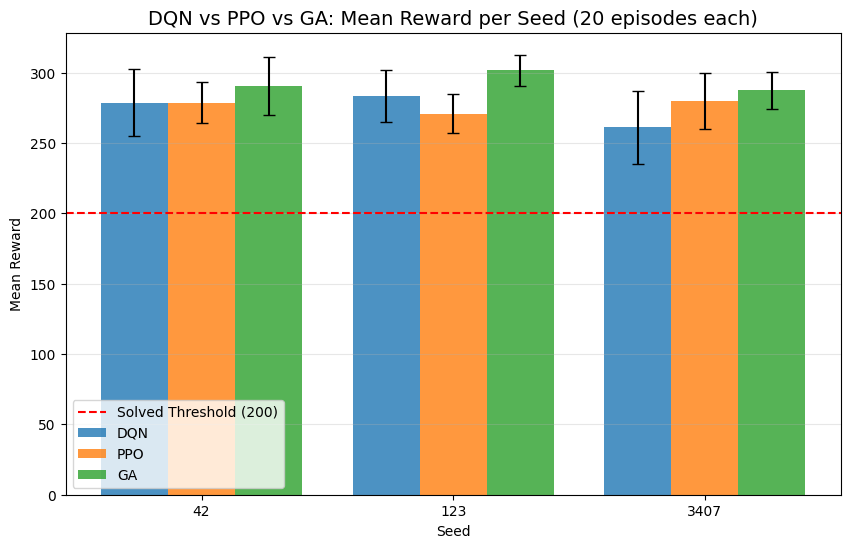

In [6]:
# Three-Way Grouped Bar Chart (per seed)

n_algos = len(ALL_ALGO_NAMES)
n_seeds = len(SEED_LIST)
bar_width = 0.8 / n_algos
x = np.arange(n_seeds)

plt.figure(figsize=(max(10, 3 * n_seeds), 6))
for i, algo_name in enumerate(ALL_ALGO_NAMES):
    means = [np.mean(evaluation_results[algo_name][s]) for s in SEED_LIST
             if s in evaluation_results.get(algo_name, {})]
    stds = [np.std(evaluation_results[algo_name][s]) for s in SEED_LIST
            if s in evaluation_results.get(algo_name, {})]
    offset = (i - (n_algos - 1) / 2) * bar_width
    plt.bar(x + offset, means, bar_width, yerr=stds, capsize=4,
            label=algo_name.upper(), color=ALL_ALGO_COLORS[algo_name], alpha=0.8)

plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.xticks(x, [str(s) for s in SEED_LIST])
plt.title(f"DQN vs PPO vs GA: Mean Reward per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
plt.xlabel("Seed")
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

**Figure 2.1** - Mean evaluation reward per seed for DQN, PPO, and GA, with standard deviation error bars. All three algorithms exceed the solved threshold (200) across all seeds.

The next chart collapses all seeds into a single overall mean reward per algorithm, providing a high-level comparison of aggregate performance.

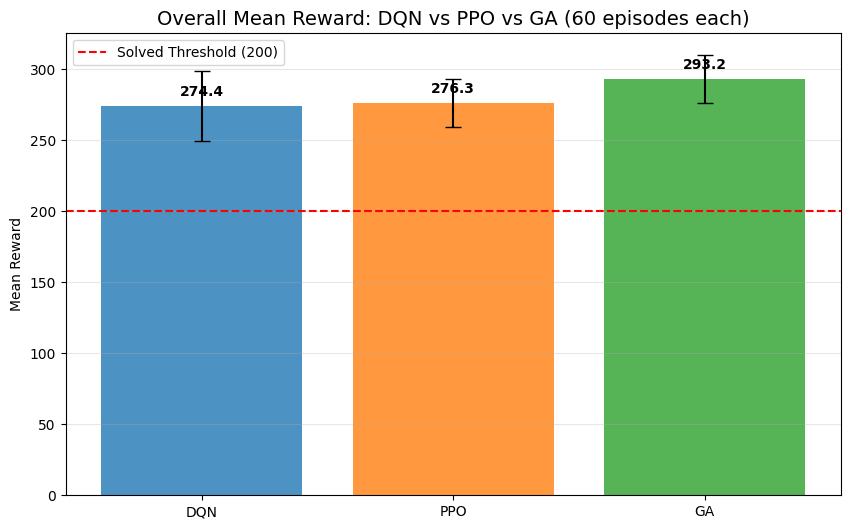

In [7]:
# Three-Way Overall Mean Reward Bar Chart

overall_means = []
overall_stds = []
for algo_name in ALL_ALGO_NAMES:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST
                            if s in evaluation_results.get(algo_name, {})])
    overall_means.append(np.mean(all_r))
    overall_stds.append(np.std(all_r))

plt.figure(figsize=(10, 6))
bars = plt.bar([a.upper() for a in ALL_ALGO_NAMES], overall_means, yerr=overall_stds,
               capsize=6, color=[ALL_ALGO_COLORS[a] for a in ALL_ALGO_NAMES], alpha=0.8)
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')

for bar, mean in zip(bars, overall_means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.title(f"Overall Mean Reward: DQN vs PPO vs GA ({EVALUATION_EPISODES * len(SEED_LIST)} episodes each)", fontsize=14)
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

**Figure 2.2** - Overall mean evaluation reward per algorithm, aggregated across all seeds and episodes (60 episodes each). All three approaches achieve mean rewards well above the solved threshold.

The overlaid histogram below shows the full reward distribution for each algorithm, combining all seeds. This reveals the spread, overlap, and shape of the reward distributions beyond what summary statistics capture.

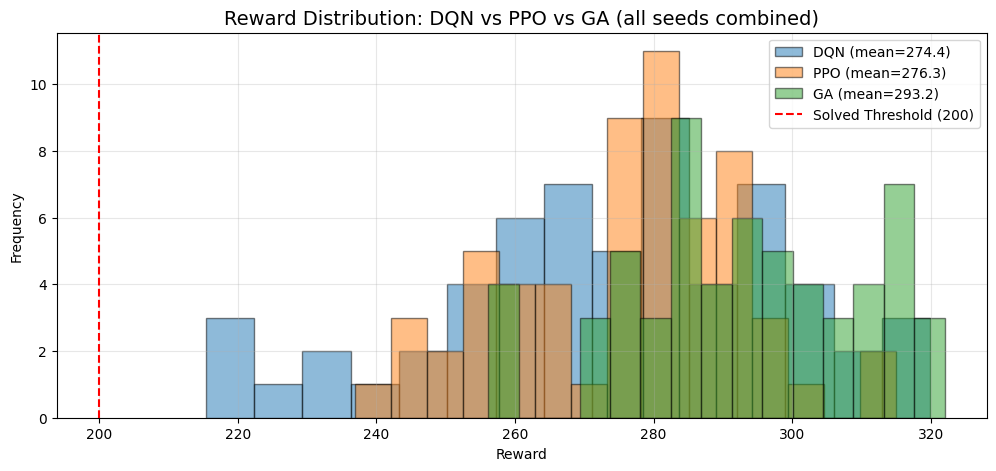

In [8]:
# Three-Way Reward Distribution Comparison

plt.figure(figsize=(12, 5))
for algo_name in ALL_ALGO_NAMES:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST
                            if s in evaluation_results.get(algo_name, {})])
    plt.hist(all_r, bins=15, alpha=0.5, color=ALL_ALGO_COLORS[algo_name],
             edgecolor='black', label=f"{algo_name.upper()} (mean={np.mean(all_r):.1f})")

plt.axvline(x=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.title('Reward Distribution: DQN vs PPO vs GA (all seeds combined)', fontsize=14)
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Figure 2.3** - Overlaid reward distributions for DQN, PPO, and GA across all seeds combined, showing the spread and overlap of evaluation outcomes.

Box plots provide a complementary view of the reward distributions, showing medians, quartiles, and outliers for each algorithm broken down by seed.

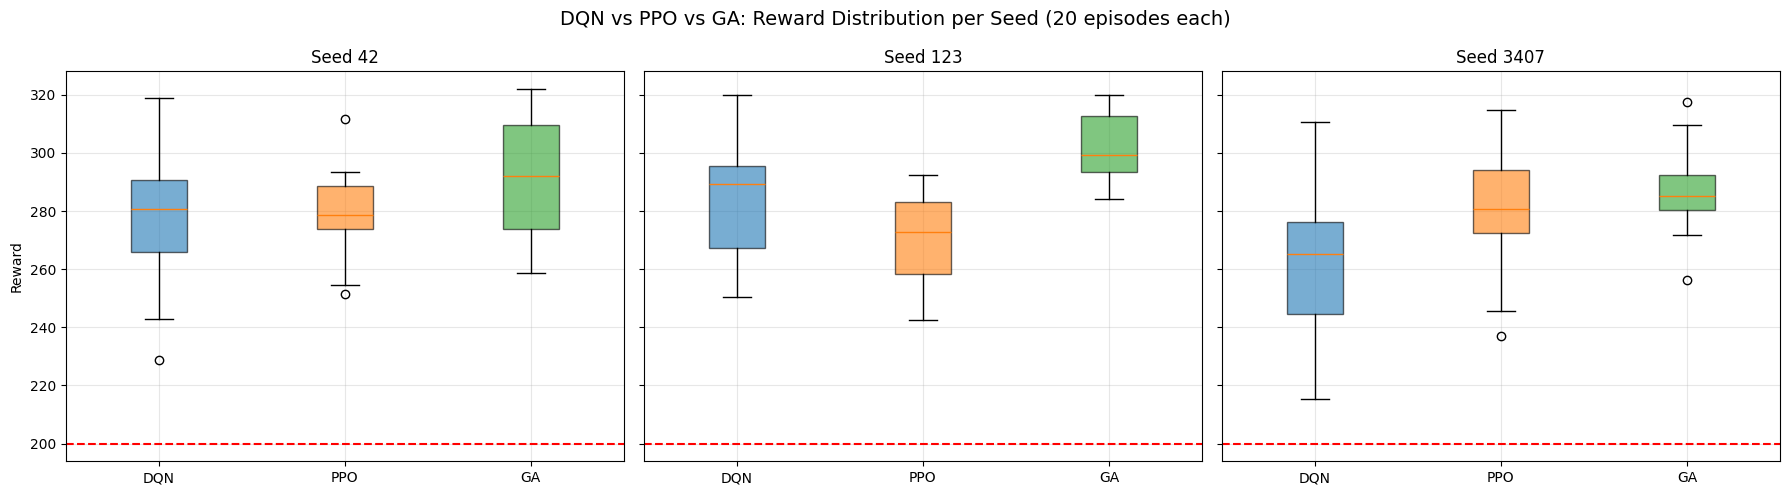

In [9]:
# Three-Way Box Plot Comparison per Seed

fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
if len(SEED_LIST) == 1:
    axes = [axes]

for ax, seed in zip(axes, SEED_LIST):
    data = [evaluation_results[algo_name][seed] for algo_name in ALL_ALGO_NAMES
            if seed in evaluation_results.get(algo_name, {})]
    bp = ax.boxplot(data, tick_labels=[a.upper() for a in ALL_ALGO_NAMES], patch_artist=True)
    for patch, algo_name in zip(bp['boxes'], ALL_ALGO_NAMES):
        patch.set_facecolor(ALL_ALGO_COLORS[algo_name])
        patch.set_alpha(0.6)
    ax.axhline(y=200, color='red', linestyle='--')
    ax.set_title(f"Seed {seed}")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Reward")
fig.suptitle(f"DQN vs PPO vs GA: Reward Distribution per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
plt.tight_layout()
plt.show()

**Figure 2.4** - Box plot comparison of reward distributions per seed for DQN, PPO, and GA. The boxes show the interquartile range, with whiskers extending to 1.5x IQR.

## 3. Statistical Significance

---

To determine whether observed performance differences are statistically meaningful, pairwise Mann-Whitney U tests compare the reward distributions between all algorithm pairs (DQN vs PPO, DQN vs GA, PPO vs GA). Chi-squared tests compare success rates (proportion of episodes achieving reward >= 200). With all three algorithms achieving high success rates, the Chi-squared tests may lack discriminative power; the Mann-Whitney U tests on raw rewards provide a more sensitive comparison.

In [10]:
# Pairwise Statistical Significance Tests

algo_all_rewards = {}
for algo_name in ALL_ALGO_NAMES:
    algo_all_rewards[algo_name] = np.concatenate([
        evaluation_results[algo_name][s] for s in SEED_LIST
        if s in evaluation_results.get(algo_name, {})
    ])

pairs = [("dqn", "ppo"), ("dqn", "ga"), ("ppo", "ga")]

reward_rows = []
success_rows = []

for a1, a2 in pairs:
    r1 = algo_all_rewards[a1]
    r2 = algo_all_rewards[a2]

    # Mann-Whitney U
    mwu = stats.mannwhitneyu(r1, r2, alternative='two-sided')

    reward_rows.append({
        "Comparison": f"{a1.upper()} vs {a2.upper()}",
        "Mean 1": f"{np.mean(r1):.2f}",
        "Mean 2": f"{np.mean(r2):.2f}",
        "U Statistic": f"{float(mwu.statistic):.1f}",
        "p-value": f"{float(mwu.pvalue):.4f}",
        "Significant": "Yes" if mwu.pvalue < 0.05 else "No"
    })

    # Chi-squared for success rates
    s1 = int((r1 >= 200).sum())
    s2 = int((r2 >= 200).sum())
    f1 = len(r1) - s1
    f2 = len(r2) - s2
    contingency = np.array([[s1, f1], [s2, f2]])

    if np.all(contingency.sum(axis=0) > 0) and np.all(contingency.sum(axis=1) > 0):
        chi2_result = stats.chi2_contingency(contingency)
        chi2_stat = float(chi2_result[0])  #type: ignore
        chi2_p = float(chi2_result[1])     #type: ignore
        chi2_valid = True
    else:
        chi2_stat, chi2_p = 0.0, 1.0
        chi2_valid = False

    note = "" if chi2_valid else " (skipped)"
    success_rows.append({
        "Comparison": f"{a1.upper()} vs {a2.upper()}",
        "Success 1": f"{s1/len(r1)*100:.1f}%",
        "Success 2": f"{s2/len(r2)*100:.1f}%",
        "Test": f"Chi-squared{note}",
        "Statistic": f"{chi2_stat:.2f}",
        "p-value": f"{chi2_p:.4f}",
        "Significant": "Yes" if (chi2_valid and chi2_p < 0.05) else "No"
    })

print("*** PAIRWISE REWARD COMPARISON (Mann-Whitney U) ***")
print(f"Sample size per algorithm: {len(algo_all_rewards['dqn'])} episodes")
print()
print(pd.DataFrame(reward_rows).to_string(index=False))
print()
print("*** PAIRWISE SUCCESS RATE COMPARISON (Chi-squared) ***")
print()
print(pd.DataFrame(success_rows).to_string(index=False))

*** PAIRWISE REWARD COMPARISON (Mann-Whitney U) ***
Sample size per algorithm: 60 episodes

Comparison Mean 1 Mean 2 U Statistic p-value Significant
DQN vs PPO 274.36 276.27      1771.0  0.8811          No
 DQN vs GA 274.36 293.22       987.0  0.0000         Yes
 PPO vs GA 276.27 293.22       886.0  0.0000         Yes

*** PAIRWISE SUCCESS RATE COMPARISON (Chi-squared) ***

Comparison Success 1 Success 2                  Test Statistic p-value Significant
DQN vs PPO    100.0%    100.0% Chi-squared (skipped)      0.00  1.0000          No
 DQN vs GA    100.0%    100.0% Chi-squared (skipped)      0.00  1.0000          No
 PPO vs GA    100.0%    100.0% Chi-squared (skipped)      0.00  1.0000          No


## 4. Agent Behavior Analysis

---

Beyond aggregate reward metrics, examining how each algorithm controls the lander reveals differences in learned strategies. The action distribution shows the relative frequency of each discrete action (do nothing, fire left, fire main, fire right) across all evaluation episodes. Different algorithms may develop distinct control patterns — for example, varying reliance on the main thruster versus lateral corrections.

In [11]:
# Collect per-step data: actions and trajectories for all three algorithms

action_counts = {}
trajectory_data = {}

# --- DQN and PPO ---
for algo_name, algo_class in ALGORITHM_MAP.items():
    action_counts[algo_name] = np.zeros(len(ACTION_LABELS), dtype=int)
    trajectory_data[algo_name] = []

    for seed in SEED_LIST:
        load_path = sb3_models.get(algo_name, {}).get(seed)
        if load_path is None:
            continue

        def make_env(s=seed):
            env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
            env.reset(seed=s)
            return env

        model = algo_class.load(load_path, env=DummyVecEnv([make_env]), device=DEVICE)
        env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)

        for ep in range(EVALUATION_EPISODES):
            obs, info = env.reset(seed=seed + ep)
            done = False
            x_pos, y_pos = [obs[0]], [obs[1]]

            while not done:
                action, _ = model.predict(obs, deterministic=True)
                action_int = int(action)
                action_counts[algo_name][action_int] += 1
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                x_pos.append(obs[0])
                y_pos.append(obs[1])

            if seed == SEED_LIST[0] and ep < TRAJECTORY_EPISODES:
                trajectory_data[algo_name].append((np.array(x_pos), np.array(y_pos)))

        env.close()

# --- GA ---
action_counts["ga"] = np.zeros(len(ACTION_LABELS), dtype=int)
trajectory_data["ga"] = []

for seed in SEED_LIST:
    genome_path = ga_genomes.get(seed)
    if genome_path is None:
        continue

    genome = np.load(genome_path)
    nn = NeuralNetwork(GA_INPUT, GA_HIDDEN1, GA_HIDDEN2, GA_OUTPUT, genome)
    env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)

    for ep in range(EVALUATION_EPISODES):
        obs, _ = env.reset(seed=seed + ep)
        done = False
        x_pos, y_pos = [obs[0]], [obs[1]]

        while not done:
            output = nn.forward(obs)
            action = int(np.argmax(output))
            action_counts["ga"][action] += 1
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            x_pos.append(obs[0])
            y_pos.append(obs[1])

        if seed == SEED_LIST[0] and ep < TRAJECTORY_EPISODES:
            trajectory_data["ga"].append((np.array(x_pos), np.array(y_pos)))

    env.close()

for algo_name in ALL_ALGO_NAMES:
    total = action_counts[algo_name].sum()
    print(f"{algo_name.upper()}: {total:,} total actions across {EVALUATION_EPISODES * len(SEED_LIST)} episodes")

print("\nBehavior data collection complete.")

DQN: 14,451 total actions across 60 episodes
PPO: 16,544 total actions across 60 episodes
GA: 11,271 total actions across 60 episodes

Behavior data collection complete.


The grouped bar charts below compare action usage in both absolute counts and percentage terms across all three algorithms.

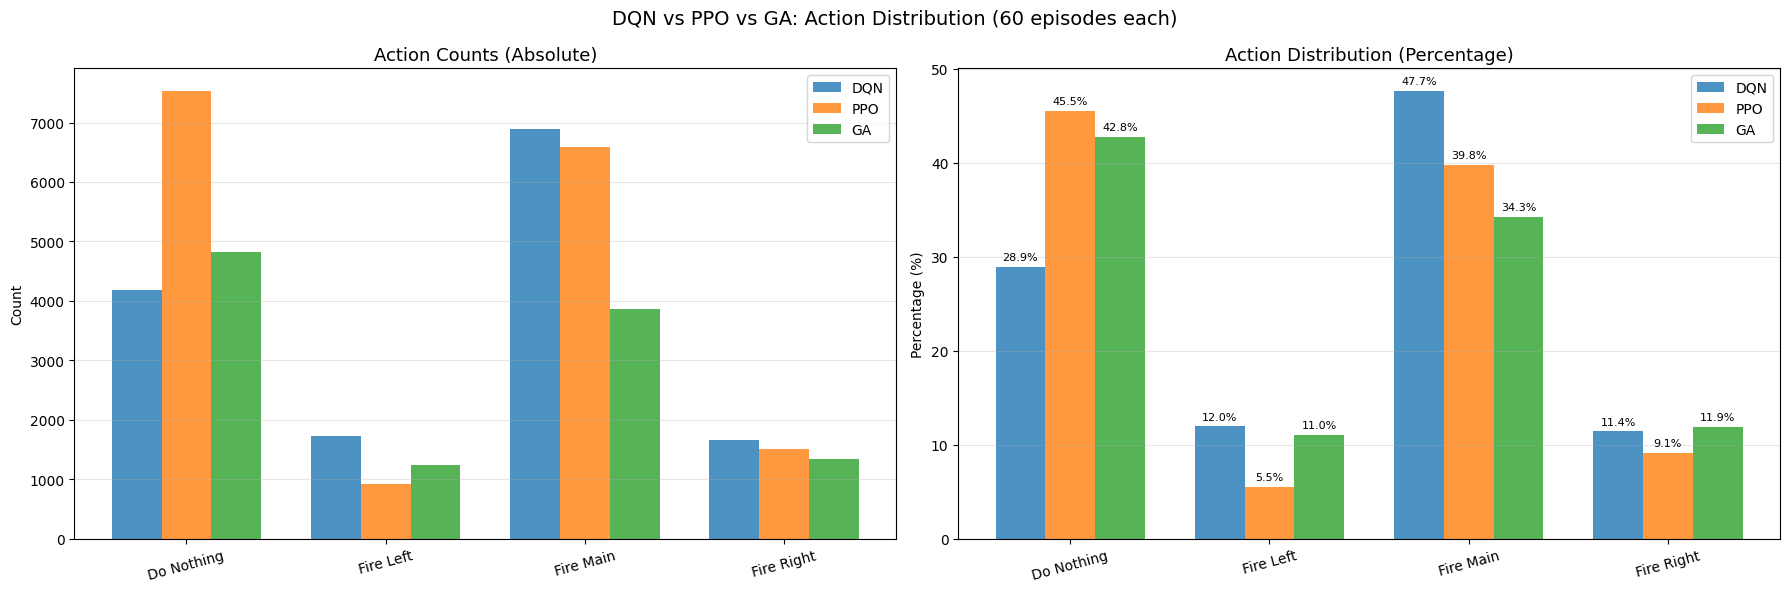

In [12]:
# Three-Way Action Distribution

n_actions = len(ACTION_LABELS)
x = np.arange(n_actions)
bar_width = 0.25

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Absolute counts
for i, algo_name in enumerate(ALL_ALGO_NAMES):
    offset = (i - 1) * bar_width
    ax1.bar(x + offset, action_counts[algo_name], bar_width,
            label=algo_name.upper(), color=ALL_ALGO_COLORS[algo_name], alpha=0.8)

ax1.set_xticks(x)
ax1.set_xticklabels(ACTION_LABELS, rotation=15)
ax1.set_title("Action Counts (Absolute)", fontsize=13)
ax1.set_ylabel("Count")
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Percentage distribution
for i, algo_name in enumerate(ALL_ALGO_NAMES):
    pcts = action_counts[algo_name] / action_counts[algo_name].sum() * 100
    offset = (i - 1) * bar_width
    bars = ax2.bar(x + offset, pcts, bar_width,
                   label=algo_name.upper(), color=ALL_ALGO_COLORS[algo_name], alpha=0.8)
    for bar, pct in zip(bars, pcts):
        ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)

ax2.set_xticks(x)
ax2.set_xticklabels(ACTION_LABELS, rotation=15)
ax2.set_title("Action Distribution (Percentage)", fontsize=13)
ax2.set_ylabel("Percentage (%)")
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

fig.suptitle(f"DQN vs PPO vs GA: Action Distribution ({EVALUATION_EPISODES * len(SEED_LIST)} episodes each)", fontsize=14)
plt.tight_layout()
plt.show()

**Figure 4.1** - Action distribution for DQN, PPO, and GA across all evaluation episodes, showing both absolute counts and relative percentages for each of the four discrete actions.

Trajectory plots show the x-y path of the lander from launch to landing for a sample of episodes. Each algorithm's trajectories are shown separately, followed by a direct overlay on the same chart for comparison.

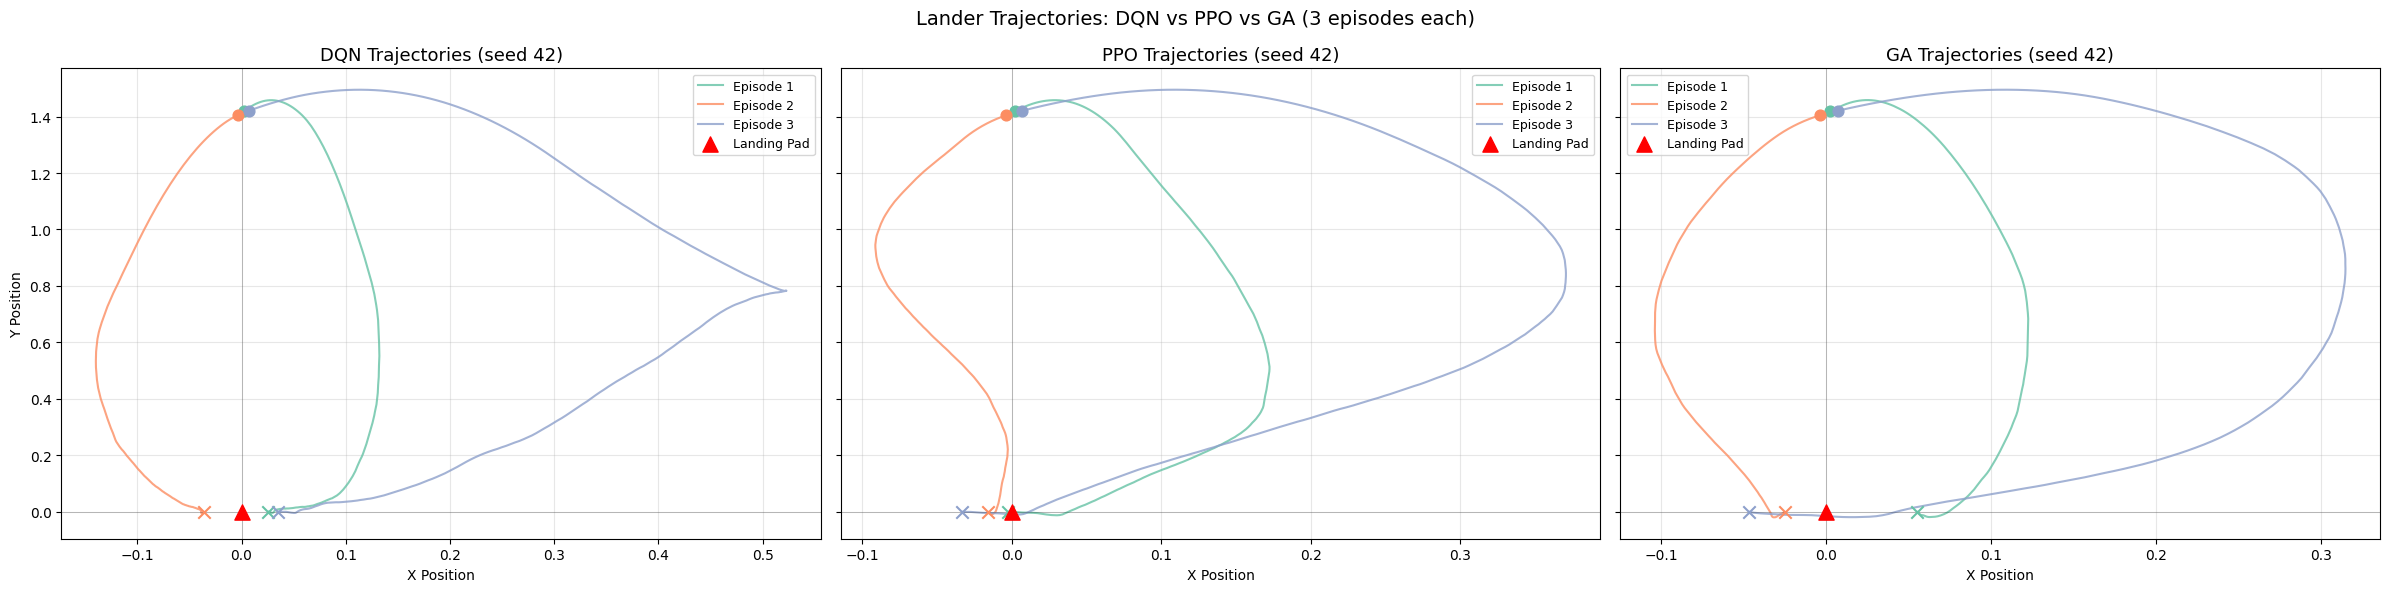

In [13]:
# Trajectory Plots: per algorithm

traj_colors = list(plt.colormaps["Set2"](range(8)))

fig, axes = plt.subplots(1, len(ALL_ALGO_NAMES), figsize=(8 * len(ALL_ALGO_NAMES), 6), sharey=True)

for ax, algo_name in zip(axes, ALL_ALGO_NAMES):
    for i, (x_pos, y_pos) in enumerate(trajectory_data[algo_name]):
        ax.plot(x_pos, y_pos, color=traj_colors[i], linewidth=1.5, alpha=0.8,
                label=f"Episode {i+1}")
        ax.scatter(x_pos[0], y_pos[0], color=traj_colors[i], marker='o', s=60, zorder=5)
        ax.scatter(x_pos[-1], y_pos[-1], color=traj_colors[i], marker='x', s=80, zorder=5)

    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.scatter(0, 0, color='red', marker='^', s=120, zorder=10, label='Landing Pad')
    ax.set_title(f"{algo_name.upper()} Trajectories (seed {SEED_LIST[0]})", fontsize=13)
    ax.set_xlabel("X Position")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Y Position")
fig.suptitle(f"Lander Trajectories: DQN vs PPO vs GA ({TRAJECTORY_EPISODES} episodes each)", fontsize=14)
plt.tight_layout()
plt.show()

**Figure 4.2** - Sample landing trajectories (x-y position) for each algorithm, showing the spatial path from launch to touchdown. Circles mark the start position, crosses mark the end position.

The overlay below places one trajectory from each algorithm on the same axes, making it easier to compare the flight profiles directly.

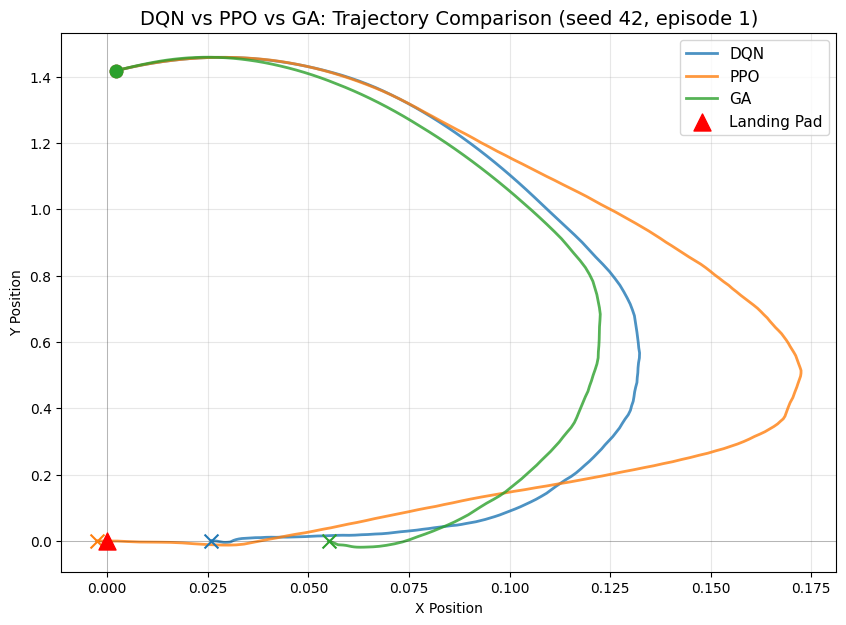

In [14]:
# Three-Way Trajectory Overlay

plt.figure(figsize=(10, 7))

for algo_name in ALL_ALGO_NAMES:
    if trajectory_data[algo_name]:
        x_pos, y_pos = trajectory_data[algo_name][0]
        plt.plot(x_pos, y_pos, color=ALL_ALGO_COLORS[algo_name], linewidth=2, alpha=0.8,
                 label=f"{algo_name.upper()}")
        plt.scatter(x_pos[0], y_pos[0], color=ALL_ALGO_COLORS[algo_name], marker='o', s=80, zorder=5)
        plt.scatter(x_pos[-1], y_pos[-1], color=ALL_ALGO_COLORS[algo_name], marker='x', s=100, zorder=5)

plt.scatter(0, 0, color='red', marker='^', s=150, zorder=10, label='Landing Pad')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

plt.title(f"DQN vs PPO vs GA: Trajectory Comparison (seed {SEED_LIST[0]}, episode 1)", fontsize=14)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

**Figure 4.3** - Direct overlay of one landing trajectory per algorithm on the same chart, illustrating differences in flight profile and approach strategy.

## 5. Visualizations

---

The animated GIFs below show a single deterministic episode for each algorithm and seed, providing a visual impression of the learned landing behaviour. Each GIF renders the full episode from launch to termination.

Generating GIF for DQN seed 42...
  Saved: /home/logus/env/iscte/taap_p2/report/outputs_comparison/dqn_seed42.gif


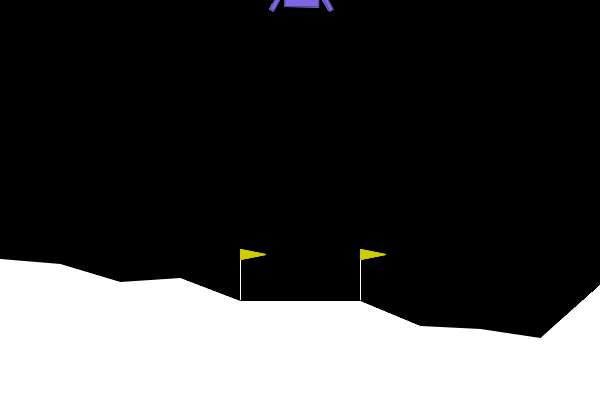

Generating GIF for DQN seed 123...
  Saved: /home/logus/env/iscte/taap_p2/report/outputs_comparison/dqn_seed123.gif


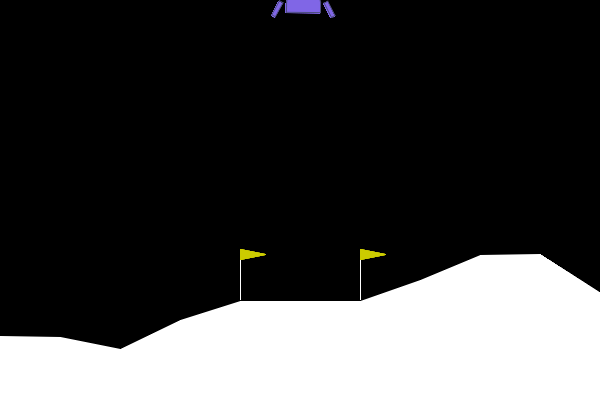

Generating GIF for DQN seed 3407...
  Saved: /home/logus/env/iscte/taap_p2/report/outputs_comparison/dqn_seed3407.gif


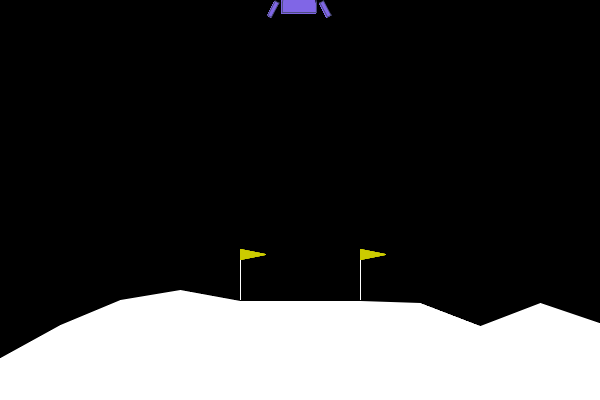

Generating GIF for PPO seed 42...
  Saved: /home/logus/env/iscte/taap_p2/report/outputs_comparison/ppo_seed42.gif


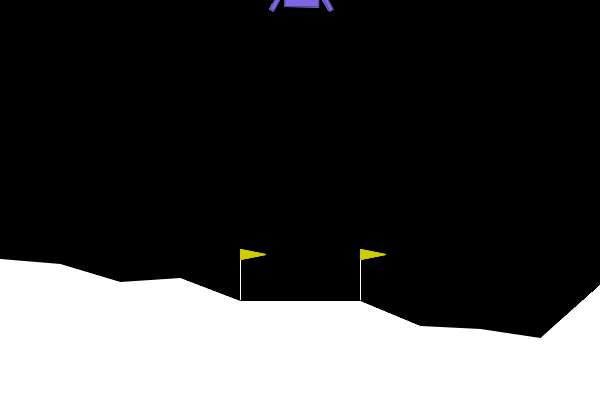

Generating GIF for PPO seed 123...
  Saved: /home/logus/env/iscte/taap_p2/report/outputs_comparison/ppo_seed123.gif


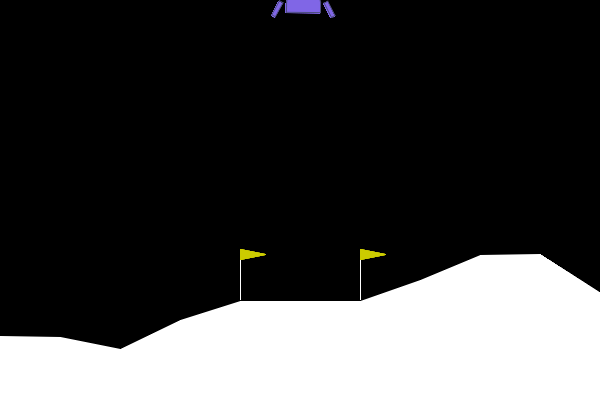

Generating GIF for PPO seed 3407...
  Saved: /home/logus/env/iscte/taap_p2/report/outputs_comparison/ppo_seed3407.gif


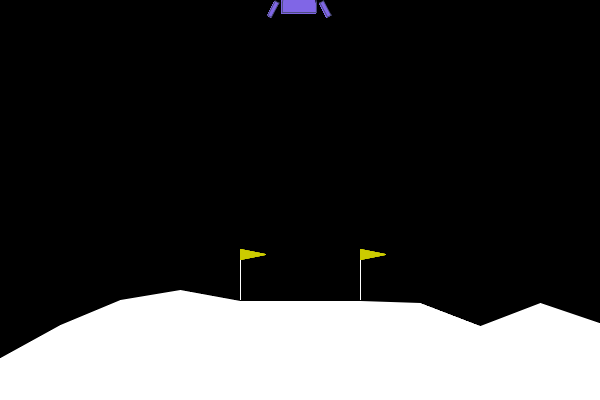

Generating GIF for GA seed 42...
  Saved: /home/logus/env/iscte/taap_p2/report/outputs_comparison/ga_seed42.gif


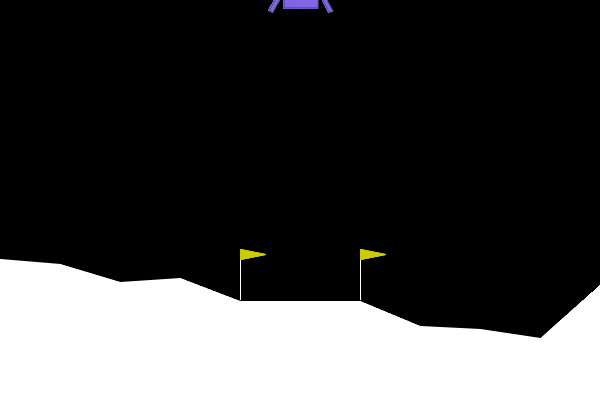

Generating GIF for GA seed 123...
  Saved: /home/logus/env/iscte/taap_p2/report/outputs_comparison/ga_seed123.gif


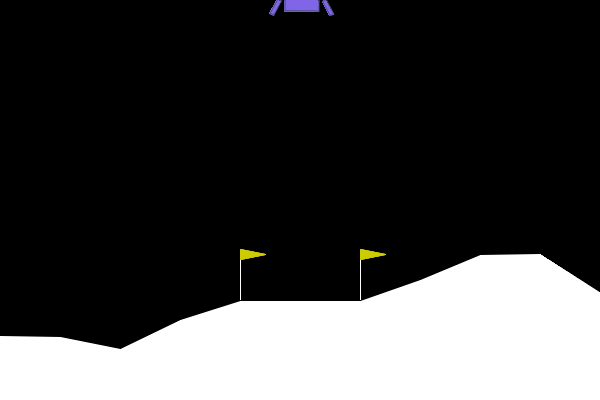

Generating GIF for GA seed 3407...
  Saved: /home/logus/env/iscte/taap_p2/report/outputs_comparison/ga_seed3407.gif


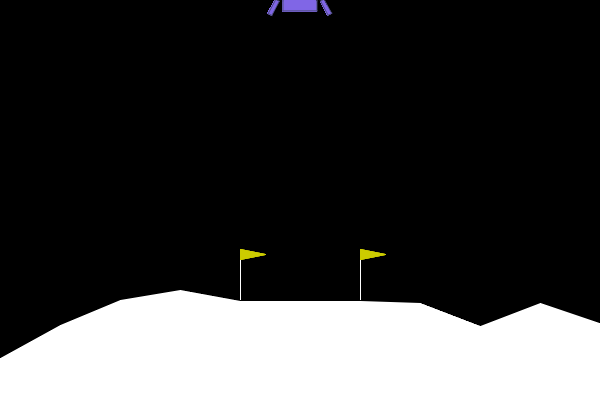

In [15]:
# GIF Visualizations for all three algorithms

output_dir = os.path.join(NOTEBOOK_DIR, "outputs_comparison")
os.makedirs(output_dir, exist_ok=True)

# --- DQN and PPO ---
for algo_name, algo_class in ALGORITHM_MAP.items():
    for seed in SEED_LIST:
        load_path = sb3_models.get(algo_name, {}).get(seed)
        if load_path is None:
            continue

        print(f"Generating GIF for {algo_name.upper()} seed {seed}...")

        def make_vis_env(s=seed):
            env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
            env.reset(seed=s)
            return env

        model = algo_class.load(load_path, env=DummyVecEnv([make_vis_env]), device=DEVICE)
        vis_env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
        frames = []
        obs, _ = vis_env.reset(seed=seed)
        done = False

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = vis_env.step(action)
            done = terminated or truncated
            frames.append(vis_env.render())

        vis_env.close()
        gif_path = os.path.join(output_dir, f"{algo_name}_seed{seed}.gif")
        imageio.mimsave(gif_path, frames, fps=30)
        print(f"  Saved: {gif_path}")
        display(Image(filename=gif_path))

# --- GA ---
for seed in SEED_LIST:
    genome_path = ga_genomes.get(seed)
    if genome_path is None:
        continue

    print(f"Generating GIF for GA seed {seed}...")
    genome = np.load(genome_path)
    nn = NeuralNetwork(GA_INPUT, GA_HIDDEN1, GA_HIDDEN2, GA_OUTPUT, genome)
    vis_env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
    frames = []
    obs, _ = vis_env.reset(seed=seed)
    done = False

    while not done:
        frames.append(vis_env.render())
        output = nn.forward(obs)
        action = np.argmax(output)
        obs, reward, terminated, truncated, _ = vis_env.step(action)
        done = terminated or truncated

    vis_env.close()
    gif_path = os.path.join(output_dir, f"ga_seed{seed}.gif")
    imageio.mimsave(gif_path, frames, fps=30)
    print(f"  Saved: {gif_path}")
    display(Image(filename=gif_path))

**Figure 5.1** - Animated visualizations of a single deterministic episode for each algorithm and seed, showing the learned landing policy in action.

## 6. Conclusions

---

This annex compared the final policy quality of three optimization approaches — DQN, PPO, and a genetic algorithm — evaluated under identical conditions on the LunarLander-v3 environment.

All three algorithms successfully solved the environment, achieving 100% success rates across all seeds. DQN achieved a mean reward of 274.36, PPO achieved 276.27, and the GA achieved 293.22. While all three approaches produced effective landing policies, the observed performance differences should be interpreted in context:

- **DQN and PPO** are gradient-based deep RL methods that learned effective policies using 1.5M environment steps each, with large network architectures (~70k parameters). These methods exploit the temporal structure of experience — sequences of states, actions, and rewards — to efficiently assign credit to individual decisions.

- **The GA** used a much smaller network (244 parameters) but required approximately 225M environment steps (150x more) to achieve its results. It has no mechanism for temporal credit assignment and relies entirely on scalar fitness signals.

The fact that all three approaches converge to high-quality policies on this environment reflects the characteristics of LunarLander-v3 itself: an 8-dimensional continuous observation space, 4 discrete actions, dense reward shaping, and short episodes. These properties make the problem tractable for diverse optimization approaches.

The summary table below captures the key dimensions of each approach.

In [16]:
# Algorithm Comparison Summary Table

summary_rows = []
for algo_name in ALL_ALGO_NAMES:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST
                            if s in evaluation_results.get(algo_name, {})])

    if algo_name == "dqn":
        opt_method = "Gradient-based (off-policy)"
        network = "8-256-256-4 (MLP)"
        params = "~70k"
        budget = "1.5M env steps"
    elif algo_name == "ppo":
        opt_method = "Gradient-based (on-policy)"
        network = "8-256-256-4 (MLP)"
        params = "~70k"
        budget = "1.5M env steps"
    else:
        opt_method = "Evolutionary (gradient-free)"
        network = "8-10-10-4 (MLP)"
        params = "244"
        budget = "~225M env steps"

    summary_rows.append({
        "Algorithm": algo_name.upper(),
        "Optimization": opt_method,
        "Network": network,
        "Parameters": params,
        "Training Budget": budget,
        "Mean Reward": f"{np.mean(all_r):.2f}",
        "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%",
    })

print("*** ALGORITHM COMPARISON SUMMARY ***")
print(pd.DataFrame(summary_rows).to_string(index=False))

*** ALGORITHM COMPARISON SUMMARY ***
Algorithm                 Optimization           Network Parameters Training Budget Mean Reward Success Rate
      DQN  Gradient-based (off-policy) 8-256-256-4 (MLP)       ~70k  1.5M env steps      274.36       100.0%
      PPO   Gradient-based (on-policy) 8-256-256-4 (MLP)       ~70k  1.5M env steps      276.27       100.0%
       GA Evolutionary (gradient-free)   8-10-10-4 (MLP)        244 ~225M env steps      293.22       100.0%


The table above summarizes the key dimensions of each approach. The reported performance reflects evaluation on 20 deterministic episodes per seed under identical environment conditions, ensuring a fair comparison of final policy quality regardless of the different training methodologies.

The sample efficiency advantage of DQN and PPO (1.5M vs ~225M environment steps) is a fundamental property of gradient-based optimization: by computing how each weight should change based on temporal feedback, these methods converge with far fewer environment interactions. This advantage becomes increasingly significant in environments where interactions are costly, high-dimensional, or involve continuous action spaces — precisely the settings where deep reinforcement learning methods are designed to excel.